In [17]:
%pylab inline
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.visible_device_list = '1'
set_session(tf.Session(config=config))
from keras.models import load_model

import six.moves.urllib
import json
import joblib
from pywsi.io.operations import WSIReader
from pywsi.io.tiling import generate_tiles, get_all_patches_from_slide, generate_tiles_fast
import os

from keras.utils.np_utils import to_categorical
from skimage.color import rgb2gray
import matplotlib.gridspec as gridspec
from pywsi.io.tiling import generate_tiles, get_all_patches_from_slide


def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = rgb2gray(patch)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='coolwarm', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='coolwarm', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

Populating the interactive namespace from numpy and matplotlib


/home/saket/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy



In [23]:
#model = load_model('../scripts/adamlr0001-rerun-allsamples-keras-improvement-03-0.75.hdf')
model = load_model('./weights-improvement-12-0.98.hdf')

In [27]:
slide_path = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_110.tif'
json_path = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_110.json'
img_mask_dir = '/Z/personal-folders/interns/saket/github/pywsi/data/patch_img_and_mask/'

slide = WSIReader(slide_path, 40)
thumbnail = slide.get_thumbnail((slide.width/256, slide.height/256))

all_samples = get_all_patches_from_slide(slide_path=slide_path, 
                                         filter_non_tissue=True, 
                                         patch_size=256,
                                         json_filepath=json_path, )
if 'img_path' not in all_samples.columns:
    assert img_mask_dir is not None, 'Need to provide directory if img_path column is missing'
    tile_loc = all_samples.tile_loc.astype(str)
    tile_loc = tile_loc.str.replace(' ', '').str.replace(')',
                                                        '').str.replace(
                                                            '(', '')

    all_samples[['row', 'col']] = tile_loc.str.split(',', expand=True)
    all_samples['img_path'] = img_mask_dir + '/' + all_samples[[
        'uid', 'row', 'col'
    ]].apply(
        lambda x: '_'.join(x.values.tolist()),
        axis=1) + '.img.joblib.pickle'

    all_samples['mask_path'] = img_mask_dir + '/' + all_samples[[
        'uid', 'row', 'col'
    ]].apply(
        lambda x: '_'.join(x.values.tolist()),
        axis=1) + '.mask.joblib.pickle'
if not os.path.isfile('/tmp/white.img.pickle'):
    white_img = np.ones([patchsize, patchsize, 3], dtype=np.uint8) * 255
    joblib.dump(white_img, '/tmp/white.img.pickle')

# Definitely not a tumor and hence all black
if not os.path.isfile('/tmp/white.mask.pickle'):
    white_img_mask = np.ones([patchsize, patchsize], dtype=np.uint8) * 0
    joblib.dump(white_img_mask, '/tmp/white.mask.pickle')

all_samples.loc[all_samples.is_tissue == False,
                'img_path'] = '/tmp/white.img.pickle'
all_samples.loc[all_samples.is_tissue == False,
                'mask_path'] = '/tmp/white.mask.pickle'

In [28]:
tumors = all_samples[all_samples.is_tumor==True]
tumors.head()

,is_tissue,is_tumor,uid,slide_path,json_filepath,tile_loc,row,col,img_path,mask_path
18,True,True,tumor_110,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(29, 172)",29,172,/Z/personal-folders/interns/saket/github/pywsi...,/Z/personal-folders/interns/saket/github/pywsi...
19,True,True,tumor_110,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(29, 173)",29,173,/Z/personal-folders/interns/saket/github/pywsi...,/Z/personal-folders/interns/saket/github/pywsi...
20,True,True,tumor_110,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(29, 174)",29,174,/Z/personal-folders/interns/saket/github/pywsi...,/Z/personal-folders/interns/saket/github/pywsi...
21,True,True,tumor_110,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(29, 175)",29,175,/Z/personal-folders/interns/saket/github/pywsi...,/Z/personal-folders/interns/saket/github/pywsi...
22,True,True,tumor_110,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(29, 176)",29,176,/Z/personal-folders/interns/saket/github/pywsi...,/Z/personal-folders/interns/saket/github/pywsi...


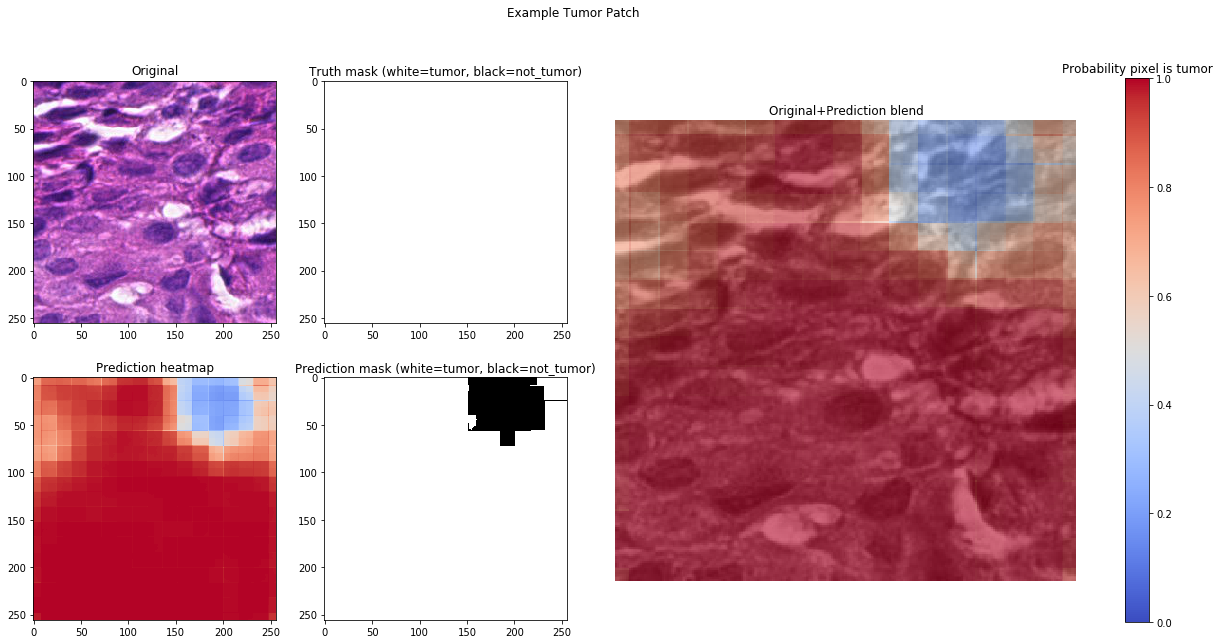

In [32]:
#all_samples
example_patch = joblib.load(tumors.loc[20, 'img_path'])
example_truth = joblib.load(tumors.loc[20, 'mask_path'])
example_truth = to_categorical(example_truth, num_classes=2).reshape(256, 256, 2)
prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')
#plt.savefig('unknown_sample.png')

In [ ]:
sample_gen = generate_tiles(tumor_002.sample(32, random_state=4), 32, shuffle=True)

example_X, example_y  = next(sample_gen)

In [7]:
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

(256, 256, 2)

In [29]:
example_truth#.argmax(axis=2)

array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       ...,

       [[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)

In [ ]:
plt.imshow(example_truth, cmap='gray')

In [19]:
example_patch

array([[[ 91,  43,  83],
        [ 92,  44,  84],
        [ 96,  45,  86],
        ...,
        [112,  56,  93],
        [154, 104, 131],
        [202, 154, 176]],

       [[ 91,  38,  80],
        [ 94,  39,  81],
        [ 98,  41,  84],
        ...,
        [153,  94, 124],
        [188, 135, 155],
        [225, 177, 191]],

       [[101,  39,  78],
        [100,  38,  77],
        [103,  38,  78],
        ...,
        [205, 144, 162],
        [228, 172, 183],
        [252, 199, 205]],

       ...,

       [[196, 144, 167],
        [157, 104, 130],
        [141,  85, 114],
        ...,
        [179, 112, 143],
        [191, 125, 152],
        [215, 150, 174]],

       [[192, 146, 159],
        [157, 109, 125],
        [143,  92, 111],
        ...,
        [163,  95, 132],
        [179, 112, 145],
        [215, 151, 178]],

       [[196, 153, 160],
        [164, 118, 128],
        [148, 100, 114],
        ...,
        [165,  97, 138],
        [171, 105, 141],
        [200, 135, 167]]

In [ ]:
x = joblib.load('/Z/personal-folders/interns/saket/github/pywsi/data/wsi_heatmap/tumor_001.joblib.pickle'
               )

In [ ]:
x

In [ ]:
layout= go.Layout(images= [dict(
        source= "./tumor_109_thumbnail.png",
        xref= "paper",
        yref= "paper",
        x= 0,
        y= 1,
        sizex= 0.2,
        sizey= 0.2,
        xanchor= "right",
        yanchor= "bottom"
      )])

In [ ]:
trace1 = [
    go.Heatmap(z=x
    )
]
fig=go.Figure(data=trace1,layout=layout)
iplot(fig)

In [ ]:
iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])


In [ ]:
response = six.moves.urllib.request.urlopen('https://raw.githubusercontent.com/plotly/datasets/master/custom_heatmap_colorscale.json')
dataset = json.load(response)

In [ ]:
str(response.read())